# Use Various tree algorithms for classification

* Random Forest 
* Gradient Boosting
* RamdomSearchCV 로 여러 알고리즘의 최적의 하이퍼 파라미터를 찾기(1)
* RamdomSearchCV 로 여러 알고리즘의 최적의 하이퍼 파라미터를 찾기(2)

# 분석 환경 구성 

## 필요 라이브러리 로드 

In [1]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy
# 시각화를 위한 seaborn, matplotlib.pyplot 을 로드합니다. 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 데이터셋 로드 

##### 데이터셋 출처
* Pima Indians Diabetes Database | Kaggle
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html  

##### 데이터 구성
* Pregnancies : 임신 횟수
* Glucose : 2시간 동안의 경구 포도당 내성 검사에서 혈장 포도당 농도
* BloodPressure : 이완기 혈압 (mm Hg)
* SkinThickness : 삼두근 피부 주름 두께 (mm), 체지방을 추정하는데 사용되는 값
* Insulin : 2시간 혈청 인슐린 (mu U / ml)
* BMI : 체질량 지수 (체중kg / 키(m)^2)
* DiabetesPedigreeFunction : 당뇨병 혈통 기능
* Age : 나이
* Outcome : 768개 중에 268개의 결과 클래스 변수(0 또는 1)는 1이고 나머지는 0입니다.

In [2]:
df = pd.read_csv("./datasets/diabetes_feature.csv") # 앞선 강의에서 전처리를 완료한 데이터를 불러옵니다. 

In [3]:
# 데이터셋을 미리보기 합니다.
print(df.shape)
df.head()

(768, 13)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_high,Insulin_nan,Insulin_log,low_glu_insulin
0,6,148,72,35,0,33.6,0.627,50,1,False,169.5,5.138735,False
1,1,85,66,29,0,26.6,0.351,31,0,False,102.5,4.639572,True
2,8,183,64,0,0,23.3,0.672,32,1,True,169.5,5.138735,False
3,1,89,66,23,94,28.1,0.167,21,0,False,94.0,4.553877,True
4,0,137,40,35,168,43.1,2.288,33,1,False,168.0,5.129899,False


## 학습과 예측에 사용할 데이터셋 만들기 

In [4]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Pregnancies_high',
       'Insulin_nan', 'Insulin_log', 'low_glu_insulin'],
      dtype='object')

In [5]:
# 설명변수로 사용할 값들만 분리합니다. 
X = df[['Glucose', 'BloodPressure', 'SkinThickness',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Pregnancies_high',
       'Insulin_nan', 'low_glu_insulin']]
X.shape

(768, 9)

In [6]:
# 예측목표인 label 값을 설정합니다.  

y = df['Outcome']
y.shape

(768,)

In [7]:
# 사이킷런에서 제공하는 model_selection 의 train_test_split 으로 만듭니다.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42) # 80:20 비율로 분할해줍니다. 

In [8]:
# train 세트의 문제와 정답의 데이터 수를 확인합니다.

X_train.shape, y_train.shape

((614, 9), (614,))

In [9]:
# test 세트의 문제와 정답의 데이터 수를 확인합니다.
X_test.shape, y_test.shape

((154, 9), (154,))

# 다양한 머신러닝 기법 활용하기 
* [결정 트리 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EA%B2%B0%EC%A0%95_%ED%8A%B8%EB%A6%AC)
* [결정 트리 학습법 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EA%B2%B0%EC%A0%95_%ED%8A%B8%EB%A6%AC_%ED%95%99%EC%8A%B5%EB%B2%95)
* [랜덤 포레스트 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8)
* [배깅 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EB%B0%B0%EA%B9%85)

* [배깅과 부스팅의 차이](https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-11-%EC%95%99%EC%83%81%EB%B8%94-%ED%95%99%EC%8A%B5-Ensemble-Learning-%EB%B0%B0%EA%B9%85Bagging%EA%B3%BC-%EB%B6%80%EC%8A%A4%ED%8C%85Boosting)

앙상블은 조화 또는 통일을 의미합니다.  
앙상블 학습법에는 두 가지가 있습니다. 배깅(Bagging)과 부스팅(Boosting)입니다.   

##### 배깅(Bootstraping Aggregation)   
배깅은 샘플을 여러 번 뽑아(Bootstrap) 각 모델을 학습시켜 결과물을 집계(Aggregration)하는 방법입니다.  
![image-1.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb4wG8O%2FbtqyfYW98AS%2FYZBtUJy3jZLyuik1R0aGNk%2Fimg.png)  
우선, 데이터로부터 부트스트랩을 합니다. (복원 랜덤 샘플링) 부트스트랩한 데이터로 모델을 학습시킵니다. 그리고 학습된 모델의 결과를 집계하여 최종 결과 값을 구합니다.  
* 최종 결과 값 도출 방식  
    - Categorical Data : 투표 방식(Votinig)으로 결과를 집계  
    - Continuous Data : 평균으로 집계     
    
Categorical Data일 때, 투표 방식으로 한다는 것은 전체 모델에서 예측한 값 중 가장 많은 값을 최종 예측값으로 선정한다는 것입니다. 6개의 결정 트리 모델이 있다고 합시다. 4개는 A로 예측했고, 2개는 B로 예측했다면 투표에 의해 4개의 모델이 선택한 A를 최종 결과로 예측한다는 것입니다.   
평균으로 집계한다는 것은 말 그대로 각각의 결정 트리 모델이 예측한 값에 평균을 취해 최종 Bagging Model의 예측값을 결정한다는 것입니다.  

배깅은 간단하면서도 파워풀한 방법입니다. 배깅 기법을 활용한 모델이 바로 랜덤 포레스트입니다.  

##### 부스팅(Boosting)
부스팅은 가중치를 활용하여 약 분류기를 강 분류기로 만드는 방법입니다. 배깅은 Deicison Tree1과 Decision Tree2가 서로 독립적으로 결과를 예측합니다. 여러 개의 독립적인 결정 트리가 각각 값을 예측한 뒤, 그 결과 값을 집계해 최종 결과 값을 예측하는 방식입니다.  
  
하지만 부스팅은 모델 간 팀워크가 이루어집니다. 처음 모델이 예측을 하면 그 예측 결과에 따라 데이터에 가중치가 부여되고, 부여된 가중치가 다음 모델에 영향을 줍니다. 잘못 분류된 데이터에 집중하여 새로운 분류 규칙을 만드는 단계를 반복합니다. 아래 그림을 통해 설명해보겠습니다.  
![image-2.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FkCejr%2FbtqyghvqEZB%2F9o3rKTEsuSIDHEfelYFJlk%2Fimg.png)  
즉,첫번째 트리의 결과가 연이은 트리들의 학습에 영향을 미치는 방식으로 작동합니다. 

## 일반적인 Descision Tree 

In [10]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state = 42)
model 

DecisionTreeClassifier(random_state=42)

In [11]:
# 학습 
model.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [12]:
# 예측 
pred_y = model.predict(X_test)

In [13]:
# 다르게 예측한 갯수를 구해서 diff_count 에 할당해 줍니다.
# DT : 28
# RF : 20
# GB : 24
(pred_y != y_test).sum()

28

In [14]:
# 예측력 평가 
# accuracy score를 구합니다.
from sklearn.metrics import accuracy_score

accuracy_score(y_test, pred_y) * 100

81.81818181818183

## Bagging : Random Forest Model 

앙상블 방법이라고 불리는 기법들은 입력된 자료로부터 한 개 이상의 결정 트리를 생성한다.   
**초기 앙상블 방법**인 **배깅(Bootstrap aggregating) 결정 트리**는 반복적으로 교체 과정을 수행하는 것과 함께 훈련 데이터를 재 샘플링하고, 합의 예측을 위한 트리를 선택하는 것으로 다수의 의사 결정 트리를 생성한다.

![image-3.png](https://t1.daumcdn.net/cfile/tistory/995E54485BD801BD36)
랜덤포레스트의 경우, 위의 그림과 같이, 전체 데이터중 일부를 각각 샘플링하여 각각의 트리를 그리고, 최종적으로 최적의 트리로 연결 짓는 방식입니다.   
따라서 해당 방법은 효과적으로 과적합을 방지해줍니다.  
해당 방법처럼 샘플링을 하는 방식을 **부트스트랩핑**이라고 합니다. 

### 모형 생성 

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
# 모형 생성 및 초기화 
model = RandomForestClassifier(random_state=42)

### 모형 학습 및 예측 

In [17]:
# 모형 학습 
model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [18]:
# 예측 
pred_y = model.predict(X_test)

### 정확도 평가 

In [19]:
# 다르게 예측한 갯수를 구해서 diff_count 에 할당해 줍니다.
# DT : 28
# RF : 20
# GB : 24
(pred_y != y_test).sum()

20

In [20]:
# 예측력 평가 
# accuracy score를 구합니다.
from sklearn.metrics import accuracy_score

accuracy_score(y_test, pred_y) * 100

87.01298701298701

일반적인 Decision Tree를 이용할 때 보다 정확도가 높은 폭으로 증가함을 볼 수 있습니다.   
하지만, Random Forest의 경우에는 트리의 결과가 **n_estimators** 옵션의 값 만큼 그려집니다(Default = 100).. 따라서, 결과의 시각화 및 해석에 있어 불리한 측면이 있습니다. 

### 시각화 

<AxesSubplot:>

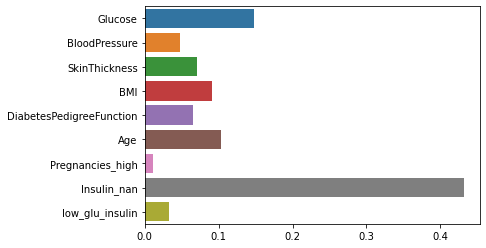

In [21]:
# feature importance 시각화 하기 
feature_names = X_train.columns.to_list()
feature_importance = model.feature_importances_

sns.barplot(x=feature_importance, y=feature_names)

모든 트리계열 알고리즘이 피처의 중요도를 알 수 있지만, Decision Tree 를 제외하고 직접적으로 트리를 시각화 하지는 못합니다.  

## Boosting : Gradient Boosting
* https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/
* 배깅과 부스팅의 차이 
![image-4.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbwr6JW%2FbtqygiHRbRk%2Fcy5hbDAPpTjCG7xa6UWxi0%2Fimg.png)
위 그림에서 나타내는 바와 같이 배깅은 병렬로 학습하는 반면, 부스팅은 순차적으로 학습합니다. 한번 학습이 끝난 후 결과에 따라 가중치를 부여합니다. 그렇게 부여된 가중치가 다음 모델의 결과 예측에 영향을 줍니다.

오답에 대해서는 높은 가중치를 부여하고, 정답에 대해서는 낮은 가중치를 부여합니다. 따라서 오답을 정답으로 맞추기 위해 오답에 더 집중할 수 있게 되는 것입니다. 

부스팅은 배깅에 비해 error가 적습니다. 즉, 성능이 좋습니다. 하지만 속도가 느리고 오버 피팅이 될 가능성이 있습니다. 그렇다면 실제 사용할 때는 배깅과 부스팅 중 어떤 것을 선택해야 할까요? 상황에 따라 다르다고 할 수 있습니다. 개별 결정 트리의 낮은 성능이 문제라면 부스팅이 적합하고, 오버 피팅이 문제라면 배깅이 적합합니다.

### 모형 생성 

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
model = GradientBoostingClassifier(random_state=42)
model 

GradientBoostingClassifier(random_state=42)

Init signature:  
GradientBoostingClassifier(  
    *,  
    loss='deviance',  
    learning_rate=0.1,  
    n_estimators=100,  
    subsample=1.0,  
    criterion='friedman_mse',  
    min_samples_split=2,  
    min_samples_leaf=1,  
    min_weight_fraction_leaf=0.0,  
    max_depth=3,  
    min_impurity_decrease=0.0,  
    min_impurity_split=None,  
    init=None,  
    random_state =None,  
    max_features=None,  
    verbose=0,  
    max_leaf_nodes=None,  
    warm_start=False,  
    validation_fraction=0.1,  
    n_iter_no_change=None,  
    tol=0.0001,  
    ccp_alpha=0.0,  
)

### 학습 및 예측 진행 

In [24]:
# 모형 학습 
model.fit(X_train,y_train)

GradientBoostingClassifier(random_state=42)

In [25]:
# 예측 수행 
pred_y = model.predict(X_test)

### 정확도 측정 

In [26]:
# 다르게 예측한 갯수를 구해서 diff_count 에 할당해 줍니다.
# DT : 28
# RF : 20
# GB : 24
(pred_y != y_test).sum()

24

In [27]:
# accuracy score를 구합니다.
# DT: 0.818
# RF: 0.870
# GBL 0.844
from sklearn.metrics import accuracy_score

accuracy_score(y_test, pred_y)

0.8441558441558441

### 시각화 
* Decision Tree 와 다르게, 트리 전체의 모습은 시각화가 불가능합니다. 
* 다만, 모든 트리 알고리즘의 장점인 feature importance의 추적은 가능합니다. 

<AxesSubplot:>

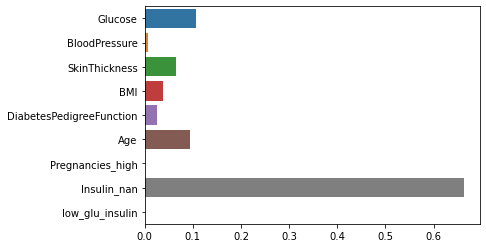

In [28]:
# feature importance 시각화 하기 
feature_names = X_train.columns.to_list()
feature_importance = model.feature_importances_

sns.barplot(x=feature_importance, y=feature_names)

# Hyper Parameter Tuning을 통해 최적 모형 결정하기 
* RandomSearchCV 를 활용해 최적 모형을 결정합니다. 

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [30]:
# 모형들을 하나의 인자로 넘겨 주기 위해, 하나의 리스트에 담습니다. 
estimators = [DecisionTreeClassifier(random_state=42),
             RandomForestClassifier(random_state=42),
             GradientBoostingClassifier(random_state=42)
            ]
estimators

[DecisionTreeClassifier(random_state=42),
 RandomForestClassifier(random_state=42),
 GradientBoostingClassifier(random_state=42)]

In [31]:
from sklearn.model_selection import RandomizedSearchCV 

# 트리의 깊이와 사용할 feature의 비율 랜덤으로 결정하기 
max_depth = np.random.randint(2,20, 10) # 2에서 20사이의 정수 10개를 무작위로 선택합니다. 
max_features = np.random.uniform(0.3, 1.0, 10) # 0.3에서 1.0사이의 값을 단일 분포에서 랜덤하게 추출해 줍니다 .

# param_distribution 결정하기 
param_distributions = {"max_depth":max_depth,
                      "max_features":max_features}

# results 리스트에 각각의 모형별 최적의 파라미터와 예측 점수 담기 
# 반복문을 통해 각각의 estimator에 대한 RandomSearch를 진행합니다. 
results = []
for estimator in estimators:
    # 각 모형에 대한 정보를 담을 리스트 내부의 임시 리스트 
    result = []
    # Decision Tree와는 다르게, 나머지 2개의 알고리즘은 트리의 갯수를 설정해야 한다 
    # 따라서 if문을 통해 나머지 두개의 경우 해당 옵션을 반영하여 randomsearch를 진행한다. 
    if estimator.__class__.__name__ != 'DecisionTreeClassifier':
        param_distributions["n_estimators"] = np.random.randint(100, 200, 10)
        
    clf = RandomizedSearchCV(estimator, 
                       param_distributions, 
                       n_iter=100,
                       scoring="accuracy",
                       n_jobs=-1,
                       cv=5, 
                       verbose=2
                      )
    # 성능평가 지표는 "accuracy"를 기준으로 진행합니다. 

    clf.fit(X_train, y_train)
    # 각 모형에 대한 정보 중, 이름만 가져옴 (cf)모형은 하나의 클레스 이기 때문에 다양한 정보가 하나의 클레스에 담겨있음) 
    result.append(estimator.__class__.__name__)
    
    result.append(clf.best_params_)
    result.append(clf.best_score_)
    result.append(clf.score(X_test, y_test))
    result.append(clf.cv_results_)
    results.append(result)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [32]:
# results에 담긴 cv 결과를 데이터 프레임으로 전환후 살펴보기 
df = pd.DataFrame(results, 
             columns=["estimator", "best_params", "train_score", "test_score", "cv_result"])
df

,estimator,best_params,train_score,test_score,cv_result
0,DecisionTreeClassifier,"{'max_features': 0.49358061963700617, 'max_dep...",0.856724,0.798701,"{'mean_fit_time': [0.024330854415893555, 0.022..."
1,RandomForestClassifier,"{'n_estimators': 134, 'max_features': 0.570000...",0.902359,0.850649,"{'mean_fit_time': [0.470473051071167, 0.668711..."
2,GradientBoostingClassifier,"{'n_estimators': 116, 'max_features': 0.406174...",0.905598,0.870130,"{'mean_fit_time': [1.339749002456665, 1.716584..."


In [33]:
pd.DataFrame(df.loc[1, "cv_result"]).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
62,0.492798,0.015965,0.031316,0.004911,134,0.570001,13,"{'n_estimators': 134, 'max_features': 0.570000...",0.886179,0.934959,0.853659,0.886179,0.950820,0.902359,0.035515,1
5,0.551250,0.099623,0.048684,0.010844,134,0.570001,16,"{'n_estimators': 134, 'max_features': 0.570000...",0.886179,0.934959,0.853659,0.886179,0.950820,0.902359,0.035515,1
18,0.632052,0.070904,0.022740,0.002630,131,0.570001,19,"{'n_estimators': 131, 'max_features': 0.570000...",0.886179,0.934959,0.853659,0.886179,0.950820,0.902359,0.035515,1
83,0.415112,0.014639,0.026131,0.000746,113,0.570001,16,"{'n_estimators': 113, 'max_features': 0.570000...",0.886179,0.934959,0.853659,0.886179,0.950820,0.902359,0.035515,1
78,0.397863,0.020454,0.026034,0.002756,110,0.570001,16,"{'n_estimators': 110, 'max_features': 0.570000...",0.886179,0.934959,0.861789,0.886179,0.942623,0.902346,0.031156,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.436074,0.009544,0.025435,0.001476,110,0.781382,9,"{'n_estimators': 110, 'max_features': 0.781382...",0.869919,0.934959,0.845528,0.894309,0.918033,0.892550,0.032169,96
49,0.475989,0.015846,0.032114,0.003857,131,0.53527,8,"{'n_estimators': 131, 'max_features': 0.535269...",0.861789,0.934959,0.861789,0.886179,0.918033,0.892550,0.029601,96
87,0.411720,0.013685,0.028127,0.001594,113,0.493581,8,"{'n_estimators': 113, 'max_features': 0.493580...",0.853659,0.934959,0.869919,0.886179,0.918033,0.892550,0.030044,98
22,0.574079,0.017837,0.029927,0.003522,164,0.869201,19,"{'n_estimators': 164, 'max_features': 0.869200...",0.869919,0.934959,0.853659,0.869919,0.926230,0.890937,0.033036,99
